<a href="https://colab.research.google.com/github/NegativeGravity/Heuristic_Trader/blob/main/PreProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import drive


drive.mount('/content/drive')



# 1. Load Data
# Please replace with your actual file path
file_path = '/content/drive/MyDrive/Heuristics_Project/Phase 2/eth_5m_with_features.csv'

try:
    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully.


In [2]:
print(df.columns.tolist())
df.shape

['open', 'high', 'low', 'close', 'volume', 'cand_body_sign_5', 'mom_cci_20', 'vol_atr_14', 'trend_lin_slope_50', 'rob_zret_60', 'rob_skew_30', 'trend_dema_20', 'vol_vwap_20', 'cand_candle_dir_1', 'vol_obv_1', 'cand_gap_1', 'trend_sma_5', 'mom_chande_14', 'vol_var_20', 'cand_close_open_ratio_1', 'rob_median_abs_dev_30', 'trend_ema_12', 'mom_roc_10', 'vol_cmf_20', 'rob_iqr_20', 'trend_ema_26', 'vol_mfi_14', 'rob_kurt_30', 'trend_sma_20', 'rob_hurst_100', 'vol_pvo_12_26', 'vol_vpt_1', 'vol_std_20', 'cand_shadow_lower_1', 'trend_tema_20', 'trend_hma_21', 'cand_range_1', 'vol_zclose_60', 'mom_willr_14', 'mom_macd_12_26', 'mom_stoch_d_14_3_3', 'cand_up_down_vol_ratio_20', 'rob_autocorr_20', 'ent_return_30', 'vol_bbw_20_2', 'vol_logret_std_20', 'vol_range_ratio_14', 'cand_shadow_upper_1', 'mom_ppo_12_26', 'trend_wma_14', 'vol_high_low_corr_20', 'vol_vroc_10', 'mom_rsi_14', 'vol_adi_14', 'vol_kc_width_20_2', 'cand_pinbar_flag_1', 'cand_shaven_head_flag_1', 'cand_shaven_bottom_flag_1', 'ent_tre

(52992, 1193)

Interpolating internal gaps...
Data sliced from index 100. Active rows: 52892
Cleaned features count: 1173
Calculating Rolling Correlation (Window=40)...


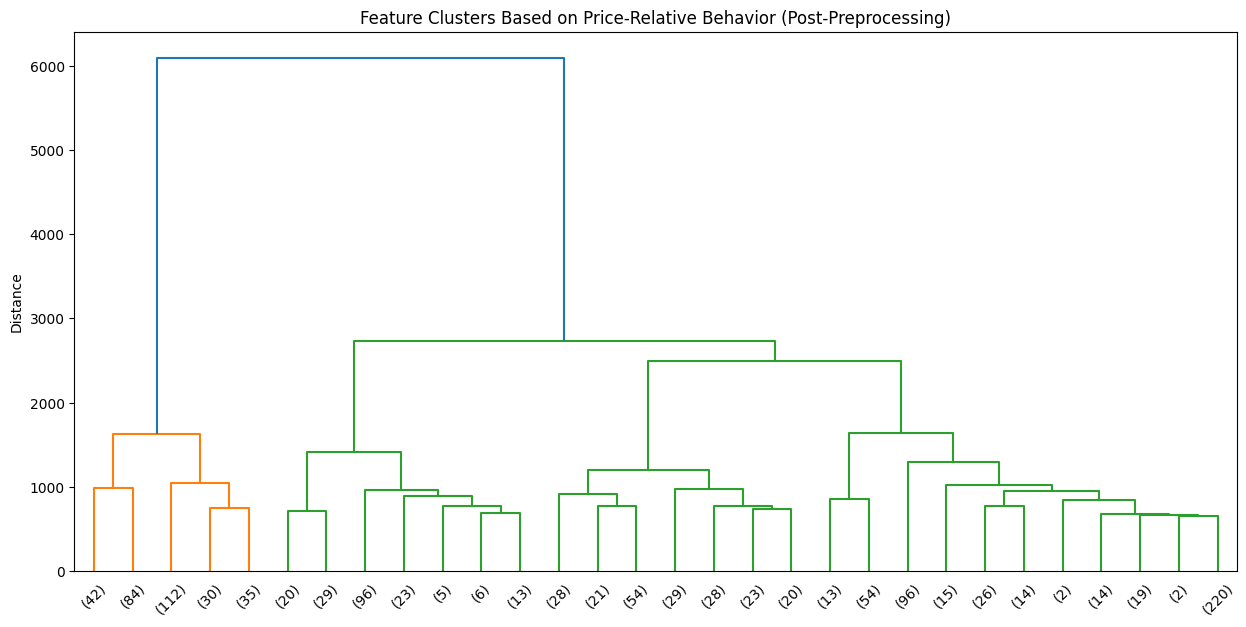


Processing complete. Features grouped into behavioral clusters.
Cluster
1    303
2    192
3    203
4     67
5    408
Name: Feature, dtype: int64


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

def full_pipeline(df, target_col='close', window_size=40, threshold=0.05, start_idx=100):
    # --- STEP 1: INITIAL CLEANING & TYPE CONVERSION ---
    df = df.copy()
    # Replace infinite values with NaN for proper interpolation
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Ensure all columns are numeric (converts strings/bools to float)
    df = df.apply(pd.to_numeric, errors='coerce')

    # --- STEP 2: INTERNAL GAP FILLING (Interpolation) ---
    # We interpolate BEFORE slicing to maintain the trend of the indicators
    print("Interpolating internal gaps...")
    df = df.interpolate(method='linear', limit_direction='both')

    # --- STEP 3: EXTERNAL GAP FILLING (Extrapolation) ---
    # Filling the edges (beginning and end)
    df = df.bfill().ffill()

    # --- STEP 4: SLICING FROM INDEX 100 ---
    # Now we drop the first 100 rows as they were only for 'warm-up'
    if len(df) <= start_idx:
        raise ValueError(f"Dataset too short! Current length: {len(df)}")

    df_active = df.iloc[start_idx:].copy().reset_index(drop=True)
    print(f"Data sliced from index {start_idx}. Active rows: {len(df_active)}")

    # --- STEP 5: FILTERING & REMOVING CONSTANTS ---
    # Drop columns that still have too many NaNs (if any were entirely empty)
    nan_ratios = df_active.isnull().mean()
    cols_to_drop = nan_ratios[nan_ratios > threshold].index
    cols_to_drop = [c for c in cols_to_drop if c != target_col]
    df_active = df_active.drop(columns=cols_to_drop)

    # Remove columns that don't change (Zero Variance)
    constant_cols = [col for col in df_active.columns if df_active[col].nunique() <= 1]
    df_active = df_active.drop(columns=constant_cols)
    print(f"Cleaned features count: {len(df_active.columns) - 1}")

    # --- STEP 6: ROLLING CORRELATION ---
    print(f"Calculating Rolling Correlation (Window={window_size})...")
    rolling_corr_list = []
    feature_names = []
    target_series = df_active[target_col]

    for col in df_active.columns:
        if col != target_col:
            # We use correlation to see how features 'move' with price
            corr = target_series.rolling(window=window_size).corr(df_active[col])
            rolling_corr_list.append(corr)
            feature_names.append(col)

    rolling_corr_df = pd.concat(rolling_corr_list, axis=1)
    rolling_corr_df.columns = feature_names

    # --- STEP 7: POST-ROLLING CLEANUP (Crucial for Clustering) ---
    # Rolling correlation creates NaNs at its own start; we back-fill them
    rolling_corr_df = rolling_corr_df.bfill().ffill()
    # Clip values to stay within [-1, 1] to avoid float precision errors
    rolling_corr_df = rolling_corr_df.clip(lower=-1.0, upper=1.0).fillna(0)

    # --- STEP 8: CLUSTERING ---
    # Transpose so features are the samples to be clustered
    corr_paths = rolling_corr_df.T

    # Scale to compare the 'behavior/shape' rather than absolute correlation level
    scaler = StandardScaler()
    corr_paths_scaled = scaler.fit_transform(corr_paths)

    # Hierarchical Clustering using Ward's linkage
    Z = linkage(corr_paths_scaled, method='ward')

    return df_active, rolling_corr_df, Z

# --- RUNNING THE PIPELINE ---
try:
    # Use your target column name (e.g., 'close')
    df_final, rolling_results, Z_matrix = full_pipeline(df, target_col='close', start_idx=100)

    # --- VISUALIZATION ---
    plt.figure(figsize=(15, 7))
    dendrogram(Z_matrix, truncate_mode='lastp', p=30, leaf_font_size=10)
    plt.title('Feature Clusters Based on Price-Relative Behavior (Post-Preprocessing)')
    plt.ylabel('Distance')
    plt.show()

    # Create Group Labels
    num_clusters = 5 # You can change this number
    cluster_labels = fcluster(Z_matrix, t=num_clusters, criterion='maxclust')
    feature_mapping = pd.DataFrame({'Feature': rolling_results.columns, 'Cluster': cluster_labels})

    print("\nProcessing complete. Features grouped into behavioral clusters.")
    print(feature_mapping.groupby('Cluster')['Feature'].count())

except Exception as e:
    print(f"Pipeline Error: {e}")

In [11]:
cluster_groups = feature_mapping.groupby('Cluster')['Feature'].apply(list).to_dict()

# Print the names for each cluster (Showing first 10 for each to keep it clean)
for cluster_id, features in cluster_groups.items():
    print(f"--- Cluster {cluster_id} (Total Features: {len(features)}) ---")
    # You can print all of them, but here we show a sample
    print(features[:20], "... \n")

# Optional: Save the mapping to a CSV file to open in Excel
feature_mapping.sort_values('Cluster').to_csv('feature_clusters_report.csv', index=False)
print("Full report saved as 'feature_clusters_report.csv'")

--- Cluster 1 (Total Features: 303) ---
['open', 'high', 'low', 'mom_cci_20', 'trend_dema_20', 'vol_obv_1', 'trend_sma_5', 'mom_chande_14', 'trend_ema_12', 'mom_roc_10', 'vol_cmf_20', 'vol_mfi_14', 'vol_vpt_1', 'trend_tema_20', 'trend_hma_21', 'vol_zclose_60', 'mom_willr_14', 'mom_macd_12_26', 'mom_stoch_d_14_3_3', 'cand_up_down_vol_ratio_20'] ... 

--- Cluster 2 (Total Features: 192) ---
['cand_body_sign_5', 'trend_lin_slope_50', 'rob_zret_60', 'rob_skew_30', 'vol_vwap_20', 'cand_candle_dir_1', 'cand_close_open_ratio_1', 'trend_ema_26', 'trend_sma_20', 'price_midhl_dist_1', 'risk_dd_speed_10', 'trend_aroon_down_25', 'vol_skew_30', 'vol_vfi_26', 'trend_kama_21', 'fib_extension_near_1_272', 'internal_range_shift_20', 'range_breakout_flag_50', 'premium_discount_balance_50', 'range_rotation_index_20'] ... 

--- Cluster 3 (Total Features: 203) ---
['vol_atr_14', 'vol_var_20', 'rob_median_abs_dev_30', 'rob_iqr_20', 'vol_pvo_12_26', 'vol_std_20', 'vol_bbw_20_2', 'vol_logret_std_20', 'vol_kc_